In [1]:
import numpy as np

import dolfinx
import ufl
from dolfinx.fem import Function, FunctionSpace, dirichletbc, Constant, Expression, locate_dofs_topological
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from ufl import (FiniteElement, MixedElement, VectorElement, grad, inner,
                 split)
import pyvista
from dolfinx import plot, log
from dolfinx.nls.petsc import NewtonSolver

from mpi4py import MPI
from petsc4py import PETSc
from tqdm import tqdm

## Parameters of the geometry and the material

In [2]:
# the radius of the cylinder
r = 1.016 

# the length of the cylinder
L = 3.048 

# the Young's modulus and Poisson's ratio
E, nu = 2.0685E7, 0.3 

# the shear modulus
mu = E/(2.0*(1.0 + nu)) 

# the lame parameter
lmbda = 2.0*mu*nu/(1.0 - 2.0*nu) 

# the thickness of the cylinder
t = 0.03 

# Generate the mesh in the parameter space 
$x_1 \in [- \pi / 2, \pi /2], x_2 \in [0, L]$

In [3]:
mesh = create_rectangle(MPI.COMM_WORLD, np.array([[-np.pi / 2, 0], [np.pi / 2, L]]), [20, 20], CellType.triangle)
tdim = mesh.topology.dim

## Plot the parameter space

In [5]:
pyvista.start_xvfb()

topology, cell_types, geometry = plot.vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

plotter.show()

Widget(value='<iframe src="http://localhost:37265/index.html?ui=P_0x7f39653eaa20_1&reconnect=auto" class="pyvi…

# Define the initial shape

In [4]:
x = ufl.SpatialCoordinate(mesh)
phi0_ufl = ufl.as_vector([r * ufl.sin(x[0]), x[1], r * ufl.cos(x[0])])

## Plot the initial shape

In [6]:
# interpolate phi_ufl into CG2 Space

phi_FS = FunctionSpace(mesh, VectorElement("Lagrange", ufl.triangle, degree = 2, dim = 3))
phi0_expr = Expression(phi0_ufl, phi_FS.element.interpolation_points())

phi0_func = Function(phi_FS)
phi0_func.interpolate(phi0_expr)


In [7]:
topology, cell_types, x_para_space = plot.vtk_mesh(phi_FS)

x_init_shape = phi0_func.x.array.reshape((x_para_space.shape[0], len(phi0_func)))

grid_ps = pyvista.UnstructuredGrid(topology, cell_types, x_para_space)
grid_is = pyvista.UnstructuredGrid(topology, cell_types, x_init_shape)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_ps, style="wireframe", color="k")
plotter.add_mesh(grid_is, show_edges=True)

plotter.show()



Widget(value='<iframe src="http://localhost:43253/index.html?ui=P_0x7fd89c251e50_2&reconnect=auto" class="pyvi…

# Define the initial local orthonormal basis


## Unit normal basis 
$$
 \vec{n}  = \frac{\partial_1 \phi_0 \times \partial_2 \phi_0}{\| \partial_1 \phi_0 \times \partial_2 \phi_0 \|}
$$

In [5]:
def unit_normal(phi):
    n = ufl.cross(phi.dx(0), phi.dx(1))
    return n/ufl.sqrt(inner(n, n))

# the analytical expression of n0
n0_ufl = unit_normal(phi0_ufl)


### Plot the normal vectors on the initial shape

In [9]:

# create a FEM interpolation of n0 
n_FS = FunctionSpace(mesh, VectorElement("Lagrange", ufl.triangle, degree = 1, dim = 3))

n0_expr = Expression(n0_ufl, n_FS.element.interpolation_points())
n0_func = Function(n_FS)
n0_func.interpolate(n0_expr)

In [10]:
phi0_P1_expr = Expression(phi0_ufl, n_FS.element.interpolation_points())

phi0_P1 = Function(n_FS)
phi0_P1.interpolate(phi0_P1_expr)


#pyvista.start_xvfb()
topology, cell_types, geometry = plot.vtk_mesh(n_FS)


geometry_phi0_P1 = phi0_P1.x.array.reshape((geometry.shape[0], len(phi0_P1)))
geometry_n0 = n0_func.x.array.reshape((geometry.shape[0], len(n0_func)))

grid_phi0_P1 = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi0_P1)
grid_phi0_P1["n0"] = geometry_n0
glyphs = grid_phi0_P1.glyph(orient="n0", factor=0.2)


plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi0_P1, style="wireframe", color="k")
plotter.add_mesh(glyphs,  show_scalar_bar=True)

plotter.show()

Widget(value='<iframe src="http://localhost:43253/index.html?ui=P_0x7fda041b1ac0_3&reconnect=auto" class="pyvi…

## two tangent basis
$$
\vec{t}_{0i} = \mathbf{R}_0 \vec{e}_i \\
\vec{n} = \vec{t}_{03} \\
$$

Define $\vec{t}_{01}$ and $\vec{t}_{02}$ with $\vec{e}_1$ and $\vec{e}_2$ 
$$
\vec{t}_{01} = \frac{\vec{e}_2 \times \vec{n}}{\| \vec{e}_2 \times \vec{n}\|} \\
\vec{t}_{02} =   \vec{n} \times \vec{t}_{01}
$$

The corresponding rotation matrix $\mathbf{R}_0$:
$$
\mathbf{R}_0 = [\vec{t}_{01}; \vec{t}_{02}; \vec{n}]
$$



In [6]:
def tangent_1(n):
    e2 = ufl.as_vector([0, 1, 0])
    t1 = ufl.cross(e2, n)
    t1 = t1/ufl.sqrt(inner(t1, t1))
    return t1

def tangent_2(n, t1):
    t2 = ufl.cross(n, t1)
    t2 = t2/ufl.sqrt(inner(t2, t2))
    return t2

# the analytical expression of t1 and t2
t1_ufl = tangent_1(n0_ufl)
t2_ufl = tangent_2(n0_ufl, t1_ufl)

# the analytical expression of R0
def rotation_matrix(t1, t2, n):
    R = ufl.as_matrix([[t1[0], t2[0], n[0]], 
                       [t1[1], t2[1], n[1]], 
                       [t1[2], t2[2], n[2]]])
    return R

R0_ufl = rotation_matrix(t1_ufl, t2_ufl, n0_ufl)

### plot the tangent basis

In [8]:
# create a FEM interpolation of t1, t2, n0 and phi0
t_FS = FunctionSpace(mesh, VectorElement("Lagrange", ufl.triangle, degree = 1, dim = 3))

t1_expr = Expression(t1_ufl, t_FS.element.interpolation_points())
t1_func = Function(t_FS)
t1_func.interpolate(t1_expr)

t2_expr = Expression(t2_ufl, t_FS.element.interpolation_points())
t2_func = Function(t_FS)
t2_func.interpolate(t2_expr)

n0_expr = Expression(n0_ufl, t_FS.element.interpolation_points())
n0_func = Function(t_FS)
n0_func.interpolate(n0_expr)

phi0_P1_expr = Expression(phi0_ufl, t_FS.element.interpolation_points())
phi0_P1 = Function(t_FS)
phi0_P1.interpolate(phi0_P1_expr)

In [13]:
topology, cell_types, geometry = plot.vtk_mesh(t_FS)

geometry_phi0_P1 = phi0_P1.x.array.reshape((geometry.shape[0], len(phi0_P1)))
geometry_t1 = t1_func.x.array.reshape((geometry.shape[0], len(t1_func)))
geometry_t2 = t2_func.x.array.reshape((geometry.shape[0], len(t2_func)))
geometry_n0 = n0_func.x.array.reshape((geometry.shape[0], len(n0_func)))

grid_phi0_P1 = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi0_P1)

grid_phi0_P1["n0"] = geometry_n0
grid_phi0_P1["t1"] = geometry_t1
grid_phi0_P1["t2"] = geometry_t2

glyphs_n0 = grid_phi0_P1.glyph(orient="n0", factor=0.1)
glyphs_t1 = grid_phi0_P1.glyph(orient="t1", factor=0.1)
glyphs_t2 = grid_phi0_P1.glyph(orient="t2", factor=0.1)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi0_P1, style="wireframe", color="k", line_width= 0.5)
plotter.add_mesh(glyphs_n0, color = 'b', show_scalar_bar=True)
plotter.add_mesh(glyphs_t1, color = 'r', show_scalar_bar=True)
plotter.add_mesh(glyphs_t2, color = 'g', show_scalar_bar=True)
plotter.camera_position = 'xz'
plotter.camera.azimuth = -45
plotter.camera.elevation = 15
plotter.show_axes_all()

plotter.show()

Widget(value='<iframe src="http://localhost:43253/index.html?ui=P_0x7fd89c16dcd0_4&reconnect=auto" class="pyvi…

## Test the rotation matrix

In [14]:
e1 = ufl.as_vector([1, 0, 0])
e2 = ufl.as_vector([0, 1, 0])
e3 = ufl.as_vector([0, 0, 1])

t1_test_ufl = ufl.dot(R0_ufl, e1)
t2_test_ufl = ufl.dot(R0_ufl, e2)
n0_test_ufl = ufl.dot(R0_ufl, e3)

### Plot the test vectors

In [15]:
# create a FEM interpolation of t1, t2, n0 and phi0
t_FS = FunctionSpace(mesh, VectorElement("Lagrange", ufl.triangle, degree = 1, dim = 3))

t1_test_expr = Expression(t1_test_ufl, t_FS.element.interpolation_points())
t1_test_func = Function(t_FS)
t1_test_func.interpolate(t1_test_expr)

t2_test_expr = Expression(t2_test_ufl, t_FS.element.interpolation_points())
t2_test_func = Function(t_FS)
t2_test_func.interpolate(t2_test_expr)

n0_test_expr = Expression(n0_test_ufl, t_FS.element.interpolation_points())
n0_test_func = Function(t_FS)
n0_test_func.interpolate(n0_test_expr)

phi0_P1_expr = Expression(phi0_ufl, t_FS.element.interpolation_points())
phi0_P1 = Function(t_FS)
phi0_P1.interpolate(phi0_P1_expr)

In [16]:
topology, cell_types, geometry = plot.vtk_mesh(t_FS)

geometry_phi0_P1 = phi0_P1.x.array.reshape((geometry.shape[0], len(phi0_P1)))

geometry_t1_test = t1_test_func.x.array.reshape((geometry.shape[0], len(t1_test_func)))
geometry_t2_test = t2_test_func.x.array.reshape((geometry.shape[0], len(t2_test_func)))
geometry_n0_test = n0_test_func.x.array.reshape((geometry.shape[0], len(n0_test_func)))

grid_phi0_P1 = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi0_P1)

grid_phi0_P1["n0"] = geometry_n0_test
grid_phi0_P1["t1"] = geometry_t1_test
grid_phi0_P1["t2"] = geometry_t2_test

glyphs_n0 = grid_phi0_P1.glyph(orient="n0", factor=0.1)
glyphs_t1 = grid_phi0_P1.glyph(orient="t1", factor=0.1)
glyphs_t2 = grid_phi0_P1.glyph(orient="t2", factor=0.1)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi0_P1, style="wireframe", color="k", line_width= 0.5)
plotter.add_mesh(glyphs_n0, color = 'b', show_scalar_bar=True)
plotter.add_mesh(glyphs_t1, color = 'r', show_scalar_bar=True)
plotter.add_mesh(glyphs_t2, color = 'g', show_scalar_bar=True)
plotter.camera_position = 'xz'
plotter.camera.azimuth = -45
plotter.camera.elevation = 15
plotter.show_axes_all()

plotter.show()

Widget(value='<iframe src="http://localhost:43253/index.html?ui=P_0x7fd89c160e30_5&reconnect=auto" class="pyvi…

# The parameterization of director 
Update the director with two successive elementary rotations
$$
    \vec{t}_3 = \mathbf{R}_0 \cdot \vec{\Lambda_3}
$$

$$
\vec{\Lambda_3} = [\sin(\theta_2)\cos(\theta_1), -\sin(\theta_1), \cos(\theta_2)\cos(\theta_1)]^\text{T}
$$

Derivation: 


$\theta_1$, $\theta_2$ are the rotation angles about the fixed axis $\vec{e}_1$ and $\vec{e}_2$ or follower axes $\mathbf{t}_1$ and $\mathbf{t}_2$

$$
\vec{t}_i = \mathbf{R} \vec{e}_i \\

\mathbf{R}  = \text{exp}[\theta_1 \hat{\mathbf{t}}_1] \text{exp}[\theta_2 \hat{\mathbf{t}}_{02}] \mathbf{R}_0 
$$

where $\mathbf{t}_{02} = \mathbf{R}_0 \cdot \vec{e}_2 $, $\mathbf{t}_1 = \text{exp}[\theta_2 \hat{\mathbf{t}}_{02}] \cdot \mathbf{t}_{01} $

$$
\mathbf{R} = \mathbf{R}_0 \text{exp}[\theta_2 \hat{\mathbf{e}}_{2}] \text{exp}[\theta_1 \hat{\mathbf{e}}_1]

$$

In [7]:
# Update the director with two successive elementary rotations

def director(R0, theta):
    Lm3 = ufl.as_vector([ufl.sin(theta[1])*ufl.cos(theta[0]), -ufl.sin(theta[0]), ufl.cos(theta[1])*ufl.cos(theta[0])])
    d = ufl.dot(R0, Lm3)
    return d

## Test the director 

In [28]:
theta_ufl = ufl.as_vector([np.pi/4, np.pi/2])

theta_const = Constant(mesh, [np.pi/4, np.pi/2])

theta_test_FS = FunctionSpace(mesh, VectorElement("Lagrange", ufl.triangle, degree=2, dim=2))
theta_test_expr = Expression(theta_ufl, theta_test_FS.element.interpolation_points(), comm=mesh.comm)
theta_test_func = Function(theta_test_FS)
theta_test_func.interpolate(theta_test_expr)

# d0_ufl = director(R0_ufl, theta_ufl)
# d0_ufl = director(R0_ufl, theta_const)
d0_ufl = director(R0_ufl, theta_test_func)

d_FS = FunctionSpace(mesh, VectorElement("Lagrange", ufl.triangle, degree = 1, dim = 3))

d0_expr = Expression(d0_ufl, d_FS.element.interpolation_points())
d0_func = Function(d_FS)
d0_func.interpolate(d0_expr)

phi0_P1_expr = Expression(phi0_ufl, d_FS.element.interpolation_points())
phi0_P1 = Function(d_FS)
phi0_P1.interpolate(phi0_P1_expr)


In [29]:
topology, cell_types, geometry = plot.vtk_mesh(d_FS)

geometry_phi0_P1 = phi0_P1.x.array.reshape((geometry.shape[0], len(phi0_P1)))

geometry_d0 = d0_func.x.array.reshape((geometry.shape[0], len(d0_func)))

grid_phi0_P1 = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi0_P1)

grid_phi0_P1["d0"] = geometry_d0


glyphs_d0 = grid_phi0_P1.glyph(orient="d0", factor=0.1)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi0_P1, style="wireframe", color="k", line_width= 0.5)
plotter.add_mesh(glyphs_d0)

# plotter.camera_position = 'xz'
# plotter.camera.azimuth = -45
# plotter.camera.elevation = 15

plotter.enable_parallel_projection()
plotter.view_xz()
plotter.show_axes_all()

plotter.show()

Widget(value='<iframe src="http://localhost:43253/index.html?ui=P_0x7fd87c114e30_8&reconnect=auto" class="pyvi…

# Nonlinear Naghdi Shell elements

## Define element

For 3 translations $u_x$, $u_y$, and $u_z$, we use 2nd order Langrange elements enriched with 3rd order Bubble elements

For 2 rotations $\theta_1$ and $\theta_2$, we use 2nd order Langrange elements.

In [8]:
# for the 3 translation DOFs, we use the P2 + B3 enriched element
P2 = FiniteElement("Lagrange", ufl.triangle, degree = 2)
B3 = FiniteElement("Bubble", ufl.triangle, degree = 3)

# Enriched
P2B3 = P2 + B3

# for 2 rotation DOFs, we use P2 element

# mixed element for the nonlinear Naghdi shell
naghdi_shell_element = MixedElement([VectorElement(P2B3, dim = 3), VectorElement(P2, dim=2)])
naghdi_shell_FS = FunctionSpace(mesh, naghdi_shell_element)

## Define `Function`

In [9]:
q_func = Function(naghdi_shell_FS)
q_trial = ufl.TrialFunction(naghdi_shell_FS)
q_test = ufl.TestFunction(naghdi_shell_FS)

u_func, theta_func = split(q_func)

## Define metric and curvature tensor

Deformation gradient
$$
\mathbf{F} = \nabla \vec{\phi} \quad  (F_{ij} = \frac{\partial \phi_i}{\partial \xi_j}); \quad \vec{\phi} = \vec{\phi}_0 + 
\vec{u}
$$

Metric tensor $\mathbf{a} \in \mathbb{S}^2_+$ and curvature tensor $\mathbf{b} \in \mathbb{S}^2$ (First and second fundamental form)
$$
\mathbf{a} = {\nabla \vec{\phi}} ^{T} \nabla \vec{\phi} \\
\mathbf{b} = -\frac{1}{2}({\nabla \vec{\phi}} ^{T} \nabla \vec{d} + {\nabla \vec{d}} ^{T} \nabla \vec{\phi})

$$

Initial configuration, $\vec{d} = \vec{n}_0$, $\vec{\phi} = \vec{\phi}_0$, conresponding initial tensors $\mathbf{a}_0$, $\mathbf{b}_0$

In [10]:
# current deformation gradient 
F = grad(u_func) + grad(phi0_ufl) 

# current director
d = director(R0_ufl, theta_func)

# initial metric and curvature tensor a0 and b0
a0_ufl = grad(phi0_ufl).T * grad(phi0_ufl)
b0_ufl = -0.5*( grad(phi0_ufl).T * grad(n0_ufl) + grad(n0_ufl).T * grad(phi0_ufl) )

## Define strain measures

- Membrane strain tensor $\boldsymbol{\varepsilon}(\vec{u})$

$$
\boldsymbol{\varepsilon} (\vec{u})= \frac{1}{2} \left ( \mathbf{a}(\vec{u}) - \mathbf{a}_0 \right)
$$

- Bending strain tensor $\boldsymbol{\kappa}(\vec{u}, \vec{\theta})$ 

$$
\boldsymbol{\kappa}(\vec{u}, \vec{\theta}) = \mathbf{b}(\vec{u}, \vec{\theta}) - \mathbf{b}_0
$$

- transverse shear strain vector $\vec{\gamma}(\vec{u}, \vec{\theta})$ 

$$
\begin{aligned}
\vec{\gamma}(\vec{u}, \vec{\theta}) & = {\nabla \vec{\phi}(\vec{u})}^T \vec{d}(\vec{\theta}) - {\nabla\vec{\phi}_0}^T \vec{n}_0 \\
& = {\nabla \vec{\phi}(\vec{u})}^T \vec{d}(\vec{\theta}) \quad \text{if zero initial shears}
\end{aligned}
$$



In [11]:
# membrane strain
epsilon = lambda F: 0.5*(F.T * F - a0_ufl)

# bending strain
kappa = lambda F, d: -0.5 * (F.T * grad(d) + grad(d).T * F) - b0_ufl

# transverse shear strain (zero initial shear strain)
gamma = lambda F, d: F.T * d

## Define isotropic linear material model

- Membrane stiffness modulus $A^{\alpha\beta\sigma\tau}$, $D^{\alpha\beta\sigma\tau}$ (__contravariant__ components)

$$
\frac{A^{\alpha\beta\sigma\tau}}t=12\frac{D^{\alpha\beta\sigma\tau}}{t^3}=\frac{2\lambda\mu}{\lambda+2\mu}a_0^{\alpha\beta}a_0^{\sigma\tau}+\mu(a_0^{\alpha\sigma}a_0^{\beta\tau}+a_0^{\alpha\tau}a_0^{\beta\sigma})
$$

- Shear stiffness modulus $S^{\alpha\beta}$

$$
\frac{S^{\alpha\beta}}t = \alpha_s \mu a_0^{\alpha\beta} , \quad \alpha_s = \frac{5}{6}: \text{shear factor}
$$


In [12]:
a0_contra_ufl = ufl.inv(a0_ufl)
j0_ufl = ufl.det(a0_ufl)

i,j,l,m = ufl.indices(4)
A_contra_ufl = ufl.as_tensor( ( ((2.0*lmbda*mu) / (lmbda + 2.0*mu)) * a0_contra_ufl[i,j]*a0_contra_ufl[l,m]
                + 1.0*mu* (a0_contra_ufl[i,l]*a0_contra_ufl[j,m] + a0_contra_ufl[i,m]*a0_contra_ufl[j,l]) )
                ,[i,j,l,m])


## Define stress measures

- Membrane stress tensor $\mathbf{N}$

$$
\mathbf{N} = \mathbf{A} : \boldsymbol{\varepsilon}
$$

- Bending stress tensor $\mathbf{M}$

$$
\mathbf{M} = \mathbf{D} : \boldsymbol{\kappa}
$$

- Shear stress vector $\vec{T}$

$$
\vec{T} = \mathbf{S} \cdot \vec{\gamma}
$$


In [13]:
N = ufl.as_tensor(t * A_contra_ufl[i,j,l,m] * epsilon(F)[l,m], [i,j])

M = ufl.as_tensor( (t**3 / 12.0) * A_contra_ufl[i,j,l,m]*kappa(F, d)[l,m], [i,j])

T = ufl.as_tensor( (t * mu *5.0 / 6.0) * a0_contra_ufl[i, j] * gamma(F, d)[j], [i])

## Define elastic strain energy density
$\psi_{m}$, $\psi_{b}$, $\psi_{s}$ for membrane, bending and shear, respectively.

$$
\psi_m = \frac{1}{2} \mathbf{N} : \boldsymbol{\varepsilon}; \quad
\psi_b = \frac{1}{2} \mathbf{M} : \boldsymbol{\kappa}; \quad
\psi_s = \frac{1}{2} \vec{T} \cdot \vec{\gamma}
$$

In [14]:
psi_m = 0.5*inner(N, epsilon(F))

psi_b = 0.5*inner(M, kappa(F, d))

psi_s = 0.5*inner(T, gamma(F, d))

## Partial selective reduced integration (PSRI)

We introduce a parameter $\alpha \in \mathbb{R}$ that splits the membrane and shear energy in the energy functional into a weighted sum of two parts:

$$
\begin{aligned}\Pi_{N}(u,\theta)&=\Pi^b(u_h,\theta_h)+\alpha\Pi^m(u_h)+(1-\alpha)\Pi^m(u_h)\\&+\alpha\Pi^s(u_h,\theta_h)+(1-\alpha)\Pi^s(u_h,\theta_h)-W_{\mathrm{ext}},\end{aligned}
$$

We apply reduced integration to the parts weighted by the factor $(1-\alpha)$

- Optimal choice $\alpha = \frac{t^2}{h^2}$, $h$ is the diameter of the cell
- Full integration : Gauss quadrature of degree 4 (6 integral points for triangle)
- Reduced integration : Gauss quadrature of degree 2 (3 integral points for triangle)

__More on lockings__:

As we can see in the definition of bending, membrane and shear stiffness modulus:
$$
\Pi ^ b \propto t^3, \quad \Pi^m \propto t, \quad \Pi^s \propto t
$$

when thickness $t$ is very small, $\Pi^b$ is much smaller than $\Pi^m$ and $\Pi^s$. In order to find the minimum of total energy functional, it is almost equivalent to require  $\Pi^m = \Pi^s = 0$. 

However, with common FEM discretizations, this requirement is too strong, the resulting solution of $\vec{u}_h, \vec{\theta}_h$ is very close to zero even at strong external forces, unless the mesh size is small compared with the thickness.

For example, we consider shear strain $\gamma = \nabla w - \theta$, with 1st order piecewise polynomal approximations $w_h$ and $\theta_h$. The only solution for $\gamma_h = \nabla w_h - \theta_h = 0$ is $w_h = 0, \theta_h = 0$

__More on reduced integration__:

With reduced integration, the new constraint is far less restrictive. It is now possible to have nonzero solutions $u_h, \theta_h $ for $\Pi^{m,r} = \Pi^{s,r} = 0$.

How reduced integration may threaten the stability of FEM, because of the existence of spurious zero-stiffness modes. In other words, there may exist nonzero solutions $\vec{q}_{nz}$ for all the three kinds of energy equal to zero: $\Pi^{b,r}(\vec{q}_{nz}) = \Pi^{m,r}(\vec{q}_{nz}) = \Pi^{s,r}(\vec{q}_{nz}) = 0$

In [15]:
dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})
dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})

h = ufl.CellDiameter(mesh)

alpha_FS = FunctionSpace(mesh, FiniteElement("DG", ufl.triangle, 0))
alpha_expr = Expression(t**2 / h**2, alpha_FS.element.interpolation_points())

alpha = Function(alpha_FS)
alpha.interpolate(alpha_expr)

# Full integration part
Pi_PSRI = psi_b * ufl.sqrt(j0_ufl) * dx_f 
Pi_PSRI += alpha * psi_m * ufl.sqrt(j0_ufl) * dx_f
Pi_PSRI += alpha * psi_s * ufl.sqrt(j0_ufl) * dx_f

# Reduced integration part
Pi_PSRI += (1.0 - alpha) * psi_m * ufl.sqrt(j0_ufl) * dx_r
Pi_PSRI += (1.0 - alpha) * psi_s * ufl.sqrt(j0_ufl) * dx_r

## Internal Force vector and Jacobian matrix

In [16]:
Residual = ufl.derivative(Pi_PSRI, q_func, q_test)
Jacobian = ufl.derivative(Residual, q_func, q_trial)

# Boundary conditions

## Dirichlet BC



- Clamped boundary conditions at $X_1 = 0$

In [17]:
def clamped_boundary(x):
    return np.isclose(x[1], 0.0)

fdim = tdim - 1

clamped_facets = locate_entities_boundary(mesh, fdim, clamped_boundary)


u_FS, _ = naghdi_shell_FS.sub(0).collapse()
theta_FS, _ = naghdi_shell_FS.sub(1).collapse()

# u1, u2, u3 = 0 on the clamped boundary
u_clamped = Function(u_FS)
clamped_dofs_u = locate_dofs_topological((naghdi_shell_FS.sub(0), u_FS), fdim, clamped_facets)
bc_clamped_u = dirichletbc(u_clamped, clamped_dofs_u, naghdi_shell_FS.sub(0))

# theta1, theta2 = 0 on the clamped boundary
theta_clamped = Function(theta_FS)
clamped_dofs_theta = locate_dofs_topological((naghdi_shell_FS.sub(1), theta_FS), fdim, clamped_facets)
bc_clamped_theta = dirichletbc(theta_clamped, clamped_dofs_theta, naghdi_shell_FS.sub(1))


- Symmetric boundary conditions on left and right sides ($u_3 = 0, \theta_2 = 0$)

In [18]:
def symm_boundary(x):
    return np.isclose(abs(x[0]), np.pi/2)

symm_facets = locate_entities_boundary(mesh, fdim, symm_boundary)

symm_dofs_u = locate_dofs_topological((naghdi_shell_FS.sub(0).sub(2), u_FS.sub(2)), fdim, symm_facets)
bc_symm_u = dirichletbc(u_clamped, symm_dofs_u, naghdi_shell_FS.sub(0).sub(2))

symm_dofs_theta = locate_dofs_topological((naghdi_shell_FS.sub(1).sub(1), theta_FS.sub(1)), fdim, symm_facets)
bc_symm_theta = dirichletbc(theta_clamped, symm_dofs_theta, naghdi_shell_FS.sub(1).sub(1))


In [19]:
bcs = [bc_clamped_u, bc_clamped_theta, bc_symm_u, bc_symm_theta]

# Point Force 

In [20]:
def compute_cell_contributions(V, points):
    # Determine what process owns a point and what cells it lies within
    mesh = V.mesh
    _, _, owning_points, cells = dolfinx.cpp.geometry.determine_point_ownership(
        mesh._cpp_object, points, 1e-6)
    owning_points = np.asarray(owning_points).reshape(-1, 3)

    # Pull owning points back to reference cell
    mesh_nodes = mesh.geometry.x
    cmap = mesh.geometry.cmaps[0]
    ref_x = np.zeros((len(cells), mesh.geometry.dim),
                     dtype=mesh.geometry.x.dtype)
    for i, (point, cell) in enumerate(zip(owning_points, cells)):
        geom_dofs = mesh.geometry.dofmap[cell]
        ref_x[i] = cmap.pull_back(point.reshape(-1, 3), mesh_nodes[geom_dofs])

    # Create expression evaluating a trial function (i.e. just the basis function)
    u = ufl.TrialFunction(V.sub(0).sub(2))
    num_dofs = V.sub(0).sub(2).dofmap.dof_layout.num_dofs * V.sub(0).sub(2).dofmap.bs
    if len(cells) > 0:
        # NOTE: Expression lives on only this communicator rank
        expr = dolfinx.fem.Expression(u, ref_x, comm=MPI.COMM_SELF)
        values = expr.eval(mesh, np.asarray(cells, dtype=np.int32))

        # Strip out basis function values per cell
        basis_values = values[:num_dofs:num_dofs*len(cells)]
    else:
        basis_values = np.zeros(
            (0, num_dofs), dtype=dolfinx.default_scalar_type)
    return cells, basis_values

In [21]:
# Point source
if mesh.comm.rank == 0:
    points = np.array([[0.0, L, 0.0]], dtype=mesh.geometry.x.dtype)
else:
    points = np.zeros((0, 3), dtype=mesh.geometry.x.dtype)

cells, basis_values = compute_cell_contributions(naghdi_shell_FS, points)

## Test BC and point force


In [15]:
q_test_bc = Function(naghdi_shell_FS)
q_test_bc.x.array[:] = 2.0

cells, basis_values = compute_cell_contributions(naghdi_shell_FS, points)

for cell, basis_value in zip(cells, basis_values):
    dofs = naghdi_shell_FS.sub(0).sub(2).dofmap.cell_dofs(cell)
    q_test_bc.x.array[dofs] += basis_value * -10.0

dolfinx.fem.petsc.set_bc(q_test_bc.vector, bcs)
q_test_bc.x.scatter_forward()

In [13]:
U_FS = FunctionSpace(mesh, VectorElement(P2, dim = 3))
U = Function(U_FS)
U.interpolate(q_test_bc.sub(0).collapse())

with dolfinx.io.VTXWriter(mesh.comm, "u.bp", [U]) as vtx:
     vtx.write(0)
    
with dolfinx.io.VTXWriter(mesh.comm, "theta.bp", [q_test_bc.sub(1).collapse()]) as vtx:
    vtx.write(0)

In [16]:
u_id = 2

# interpolate ui from P2B3 space to P2
Ui_FS = FunctionSpace(mesh, P2)
ui_p2 = Function(Ui_FS)
ui = q_test_bc.sub(0).sub(u_id).collapse()
ui_p2.interpolate(ui)

topology, cell_types, geometry = plot.vtk_mesh(Ui_FS)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)


grid.point_data[f"u{u_id + 1}"] = ui_p2.x.array
grid.set_active_scalars(f"u{u_id + 1}")

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

plotter.show()

Widget(value='<iframe src="http://localhost:36613/index.html?ui=P_0x7febb8d4e4b0_3&reconnect=auto" class="pyvi…

In [18]:
theta_id = 0 

Theta_FS, _ = naghdi_shell_FS.sub(1).sub(theta_id).collapse()

topology, cell_types, geometry = plot.vtk_mesh(Theta_FS)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

theta = q_test_bc.sub(1).sub(theta_id).collapse()
grid.point_data[f"theta{theta_id + 1}"] = theta.x.array
grid.set_active_scalars(f"theta{theta_id + 1}")

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

plotter.show()

Widget(value='<iframe src="http://localhost:46769/index.html?ui=P_0x7faec9c9e3c0_2&reconnect=auto" class="pyvi…

# Nonlinear problem plus point source

In [22]:
import typing
from dolfinx.fem.bcs import DirichletBC
from dolfinx.fem.function import Function as _Function
from dolfinx.fem.petsc import assemble_vector, apply_lifting, set_bc

class NonlinearProblemPointSource(NonlinearProblem):
    def __init__(self, F: ufl.form.Form, u: _Function, bcs: typing.List[DirichletBC] = [],
                 J: ufl.form.Form = None, cells = [], basis_values = [], PS: float = 0.0):
        
        super().__init__(F, u, bcs, J)
        
        self.PS = PS
        self.cells = cells
        self.basis_values = basis_values
        self.function_space = u.function_space
        
    def F(self, x: PETSc.Vec, b: PETSc.Vec) -> None:
        # Reset the residual vector
        with b.localForm() as b_local:
            b_local.set(0.0)
        assemble_vector(b, self._L)

        # Add point source
        if len(self.cells) > 0:
            for cell, basis_value in zip(self.cells, self.basis_values):
                dofs = self.function_space.sub(0).sub(2).dofmap.cell_dofs(cell)
                with b.localForm() as b_local:
                    b_local.setValuesLocal(dofs, basis_value * self.PS, addv=PETSc.InsertMode.ADD_VALUES)
        
        # Apply boundary condition
        apply_lifting(b, [self._a], bcs=[self.bcs], x0=[x], scale=-1.0)
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b, self.bcs, x, -1.0)

In [23]:
problem = NonlinearProblemPointSource(Residual, q_func, bcs, Jacobian, cells, basis_values)

solver = NewtonSolver(mesh.comm, problem)

# Set Newton solver options
solver.rtol = 1e-6
solver.atol = 1e-6
solver.max_it = 30
solver.convergence_criterion = "incremental"
solver.report = True

# Modify the linear solver in each Newton iteration
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
#opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

In [24]:


# # target point
# if mesh.comm.rank == 0:
#     bb_tree = dolfinx.geometry.bb_tree(mesh, 2)
#     bb_point = np.array([[0.0, L, 0.0]], dtype=np.float64)

#     # Find the leaf that the target point is in
#     bb_cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, bb_point)

#     # Find the cell from the leaf that contains the target point
#     bb_cells = dolfinx.geometry.compute_colliding_cells(
#         mesh, bb_cell_candidates, bb_point)


In [24]:
#log.set_log_level(log.LogLevel.INFO)

PS_diff = 50.0
n_step = 40

if mesh.comm.rank == 0:
    u3_list = np.zeros(n_step + 1)
    PS_list = np.arange(0, PS_diff * (n_step + 1), PS_diff)

q_func.x.array[:] = 0.0

bb_point = np.array([[0.0, L, 0.0]], dtype=np.float64)

for i in tqdm(range(1, n_step + 1)):
    problem.PS = PS_diff * i
    n, converged = solver.solve(q_func)
    assert (converged)
    q_func.x.scatter_forward()
    if mesh.comm.rank == 0:
        print(f"Load step {i:d}, Number of iterations: {n:d}, Load: {problem.PS:.2f}", flush=True)
    
    u3_bb = None
    u3_func = q_func.sub(0).sub(2).collapse()
    if len(cells) > 0:
        u3_bb = u3_func.eval(bb_point, cells[0])[0]
        
    
    u3_bb = mesh.comm.gather(u3_bb, root=0)

    if mesh.comm.rank == 0:
        for u3 in u3_bb:
            if u3 is not None:
                u3_list[i] = u3
                break

  0%|          | 0/40 [00:00<?, ?it/s]

Load step 1, Number of iterations: 5, Load: 50.00


  2%|▎         | 1/40 [00:00<00:24,  1.56it/s]

Load step 2, Number of iterations: 6, Load: 100.00


  5%|▌         | 2/40 [00:01<00:24,  1.52it/s]

Load step 3, Number of iterations: 6, Load: 150.00


  8%|▊         | 3/40 [00:02<00:27,  1.36it/s]

Load step 4, Number of iterations: 6, Load: 200.00


 10%|█         | 4/40 [00:02<00:26,  1.38it/s]

Load step 5, Number of iterations: 6, Load: 250.00


 12%|█▎        | 5/40 [00:03<00:24,  1.41it/s]

Load step 6, Number of iterations: 6, Load: 300.00


 15%|█▌        | 6/40 [00:04<00:23,  1.44it/s]

Load step 7, Number of iterations: 6, Load: 350.00


 18%|█▊        | 7/40 [00:04<00:22,  1.45it/s]

Load step 8, Number of iterations: 6, Load: 400.00


 20%|██        | 8/40 [00:05<00:22,  1.41it/s]

Load step 9, Number of iterations: 6, Load: 450.00


 22%|██▎       | 9/40 [00:06<00:21,  1.43it/s]

Load step 10, Number of iterations: 7, Load: 500.00


 25%|██▌       | 10/40 [00:07<00:21,  1.38it/s]

Load step 11, Number of iterations: 8, Load: 550.00


 28%|██▊       | 11/40 [00:07<00:22,  1.29it/s]

Load step 12, Number of iterations: 9, Load: 600.00


 30%|███       | 12/40 [00:09<00:24,  1.15it/s]

Load step 13, Number of iterations: 11, Load: 650.00


 32%|███▎      | 13/40 [00:10<00:26,  1.02it/s]

Load step 14, Number of iterations: 10, Load: 700.00


 35%|███▌      | 14/40 [00:11<00:26,  1.02s/it]

Load step 15, Number of iterations: 9, Load: 750.00


 38%|███▊      | 15/40 [00:12<00:26,  1.05s/it]

Load step 16, Number of iterations: 8, Load: 800.00


 40%|████      | 16/40 [00:13<00:23,  1.00it/s]

Load step 17, Number of iterations: 8, Load: 850.00


 42%|████▎     | 17/40 [00:14<00:22,  1.03it/s]

Load step 18, Number of iterations: 7, Load: 900.00


 45%|████▌     | 18/40 [00:15<00:20,  1.10it/s]

Load step 19, Number of iterations: 7, Load: 950.00


 48%|████▊     | 19/40 [00:15<00:18,  1.12it/s]

Load step 20, Number of iterations: 6, Load: 1000.00


 50%|█████     | 20/40 [00:16<00:16,  1.21it/s]

Load step 21, Number of iterations: 6, Load: 1050.00


 52%|█████▎    | 21/40 [00:17<00:14,  1.27it/s]

Load step 22, Number of iterations: 6, Load: 1100.00


 55%|█████▌    | 22/40 [00:17<00:13,  1.33it/s]

Load step 23, Number of iterations: 6, Load: 1150.00


 57%|█████▊    | 23/40 [00:18<00:12,  1.31it/s]

Load step 24, Number of iterations: 6, Load: 1200.00


 60%|██████    | 24/40 [00:19<00:11,  1.36it/s]

Load step 25, Number of iterations: 6, Load: 1250.00


 62%|██████▎   | 25/40 [00:20<00:10,  1.39it/s]

Load step 26, Number of iterations: 6, Load: 1300.00


 65%|██████▌   | 26/40 [00:20<00:09,  1.41it/s]

Load step 27, Number of iterations: 6, Load: 1350.00


 68%|██████▊   | 27/40 [00:21<00:09,  1.43it/s]

Load step 28, Number of iterations: 6, Load: 1400.00


 70%|███████   | 28/40 [00:22<00:08,  1.37it/s]

Load step 29, Number of iterations: 5, Load: 1450.00


 72%|███████▎  | 29/40 [00:22<00:07,  1.48it/s]

Load step 30, Number of iterations: 6, Load: 1500.00


 75%|███████▌  | 30/40 [00:23<00:06,  1.48it/s]

Load step 31, Number of iterations: 6, Load: 1550.00


 78%|███████▊  | 31/40 [00:24<00:06,  1.48it/s]

Load step 32, Number of iterations: 6, Load: 1600.00


 80%|████████  | 32/40 [00:24<00:05,  1.48it/s]

Load step 33, Number of iterations: 5, Load: 1650.00


 82%|████████▎ | 33/40 [00:25<00:04,  1.54it/s]

Load step 34, Number of iterations: 5, Load: 1700.00


 85%|████████▌ | 34/40 [00:26<00:03,  1.59it/s]

Load step 35, Number of iterations: 5, Load: 1750.00


 88%|████████▊ | 35/40 [00:26<00:03,  1.64it/s]

Load step 36, Number of iterations: 6, Load: 1800.00


 90%|█████████ | 36/40 [00:27<00:02,  1.59it/s]

Load step 37, Number of iterations: 6, Load: 1850.00


 92%|█████████▎| 37/40 [00:27<00:01,  1.56it/s]

Load step 38, Number of iterations: 5, Load: 1900.00


 95%|█████████▌| 38/40 [00:28<00:01,  1.61it/s]

Load step 39, Number of iterations: 5, Load: 1950.00


 98%|█████████▊| 39/40 [00:29<00:00,  1.61it/s]

Load step 40, Number of iterations: 5, Load: 2000.00


100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


## Plot the deformed shape

In [25]:
# interpolate phi_ufl into CG2 Space
# log.set_log_level(log.LogLevel.OFF)

u_P2B3 = q_func.sub(0).collapse()
theta_P2 = q_func.sub(1).collapse()

phi_FS = FunctionSpace(mesh, VectorElement("Lagrange", ufl.triangle, degree = 2, dim = 3))


phi_expr = Expression(phi0_ufl + u_P2B3, phi_FS.element.interpolation_points())

phi_func = Function(phi_FS)
phi_func.interpolate(phi_expr)

u_P2 = Function(phi_FS)
u_P2.interpolate(u_P2B3)

from pathlib import Path

results_folder = Path("results/nonlinear_Naghdi")
results_folder.mkdir(exist_ok=True, parents=True)
filename = results_folder / "semi_cylinder"

with dolfinx.io.VTXWriter(mesh.comm, filename/"u_naghdi.bp", [u_P2]) as vtx:
     vtx.write(0)

with dolfinx.io.VTXWriter(mesh.comm, filename/"theta_naghdi.bp", [theta_P2]) as vtx:
     vtx.write(0)

with dolfinx.io.VTXWriter(mesh.comm, filename/"phi_naghdi.bp", [phi_func]) as vtx:
     vtx.write(0)

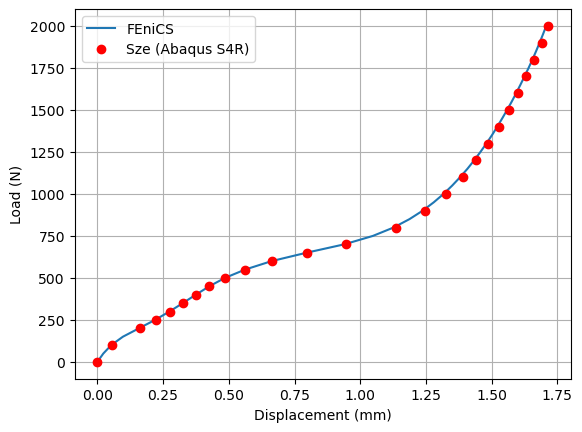

In [26]:
import matplotlib.pyplot as plt

plt.figure()
reference_Sze = np.array([
    1.e-2*np.array([0., 5.421, 16.1, 22.195, 27.657, 32.7, 37.582, 42.633,
    48.537, 56.355, 66.410, 79.810, 94.669, 113.704, 124.751, 132.653,
    138.920, 144.185, 148.770, 152.863, 156.584, 160.015, 163.211,
    166.200, 168.973, 171.505]),
    2000.*np.array([0., .05, .1, .125, .15, .175, .2, .225, .25, .275, .3,
    .325, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1.])
    ])
plt.plot(-u3_list, PS_list, label='FEniCS')
plt.plot(*reference_Sze, "or", label='Sze (Abaqus S4R)')
plt.xlabel("Displacement (mm)")
plt.ylabel("Load (N)")
plt.legend()
plt.grid()
plt.show()

In [27]:
d_deformed = director(R0_ufl, theta_P2)

d_FS = FunctionSpace(mesh, VectorElement("Lagrange", ufl.triangle, degree = 2, dim = 3))

d_expr = Expression(d_deformed, d_FS.element.interpolation_points())
d_func = Function(d_FS)
d_func.interpolate(d_expr)

In [29]:
pyvista.start_xvfb()

topology, cell_types, geometry = plot.vtk_mesh(phi_FS)

geometry_phi = phi_func.x.array.reshape((geometry.shape[0], len(phi_func)))

grid_phi = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi)

geometry_d = d_func.x.array.reshape((geometry.shape[0], len(d_func)))
grid_phi["d"] = geometry_d
glyphs_d = grid_phi.glyph(orient="d", factor=0.1)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi, style="wireframe", color="k", line_width= 0.5)
#plotter.add_mesh(glyphs_d)
plotter.enable_parallel_projection()
plotter.show_axes_all()
plotter.show()


Widget(value='<iframe src="http://localhost:44063/index.html?ui=P_0x7f8c9e9ab590_1&reconnect=auto" class="pyvi…